# Visual Question Answering and Image Captioning using BLIP and OpenVINO

Humans perceive the world through vision and language. A longtime goal of AI is to build intelligent agents that can understand the world through vision and language inputs to communicate with humans through natural language. In order to achieve this goal, vision-language pre-training has emerged as an effective approach, where deep neural network models are pre-trained on large scale image-text datasets to improve performance on downstream vision-language tasks, such as image-text retrieval, image captioning, and visual question answering.

[BLIP](https://github.com/salesforce/BLIP) is a language-image pre-training framework for unified vision-language understanding and generation. BLIP achieves state-of-the-art results on a wide range of vision-language tasks. This tutorial demonstrates how to use BLIP for visual question answering and image captioning.

The tutorial consists of the following parts:

1. Instantiate a BLIP model.
2. Convert the BLIP model to OpenVINO IR.
3. Run visual question answering and image captioning with OpenVINO.


#### Table of contents:
- [Background](#Background)
    - [Image Captioning](#Image-Captioning)
    - [Visual Question Answering](#Visual-Question-Answering)
- [Instantiate Model](#Instantiate-Model)
- [Convert Models to OpenVINO IR](#Convert-Models-to-OpenVINO-IR)
    - [Vision Model](#Vision-Model)
    - [Text Encoder](#Text-Encoder)
    - [Text Decoder](#Text-Decoder)
- [Run OpenVINO Model](#Run-OpenVINO-Model)
    - [Prepare Inference Pipeline](#Prepare-Inference-Pipeline)
    - [Select inference device](#Select-inference-device)
    - [Image Captioning](#Image-Captioning)
    - [Question Answering](#Question-Answering)
- [Interactive demo](#Interactive-demo)
- [Next steps](#Next-steps)


## Background
[back to top ⬆️](#Table-of-contents:)

Visual language processing is a branch of artificial intelligence that focuses on creating algorithms designed to enable computers to more accurately understand images and their content.

Popular tasks include:

* **Text to Image Retrieval** - a semantic task that aims to find the most relevant image for a given text description.
* **Image Captioning** - a semantic task that aims to provide a text description for image content.
* **Visual Question Answering** - a semantic task that aims to answer questions based on image content.

As shown in the diagram below, these three tasks differ in the input provided to the AI system. For text-to-image retrieval, you have a predefined gallery of images for search and a user-requested text description (query). Image captioning can be represented as a particular case of visual question answering, where you have a predefined question "What is in the picture?" and various images provided by a user. For visual question answering, both the text-based question and image context are variables requested by a user.

![](https://user-images.githubusercontent.com/29454499/221755717-a5b51b7e-523c-461f-b30c-4edbfaf9a134.png)

This notebook does not focus on Text to Image retrieval. Instead, it considers Image Captioning and Visual Question Answering.

### Image Captioning
[back to top ⬆️](#Table-of-contents:)

Image Captioning is the task of describing the content of an image in words. This task lies at the intersection of computer vision and natural language processing. Most image captioning systems use an encoder-decoder framework, where an input image is encoded into an intermediate representation of the information in the image, and then decoded into a descriptive text sequence.

![](https://user-images.githubusercontent.com/29454499/221640847-1868117c-aac0-4806-99a4-34f218e98bb8.png)

### Visual Question Answering
[back to top ⬆️](#Table-of-contents:)

Visual Question Answering (VQA) is the task of answering text-based questions about image content.

![](https://user-images.githubusercontent.com/29454499/221641984-3c6d8b2f-dd0d-4302-a4d8-0f8564fca772.png)

For a better understanding of how VQA works, let us consider a traditional NLP task like Question Answering, which aims to retrieve the answer to a question from a given text input. Typically, a question answering pipeline consists of three steps:

![](https://user-images.githubusercontent.com/29454499/221760881-378f1ea8-eadc-4610-aff0-69ecabf62fff.png)

1. Question analysis - analysis of provided question in natural language form to understand the object in the question and additional context. For example, if you have a question like "How many bridges in Paris?", question words *"how many"* gives a hint that the answer is more likely to be a number, *"bridges"* is the target object of the question and *" in Paris"* serves as additional context for the search.
2. Build query for search - use analyzed results to formalize query for finding the most relevant information.
3. Perform a search in the knowledge base - send the query to a knowledge base, typically provided text documents or databases serve as a source of knowledge.

![](https://user-images.githubusercontent.com/29454499/222094861-3cafdf9f-d700-4741-b6c5-fb09c1a4da9a.png)

The difference between text-based question answering and visual question answering is that an image is used as context and the knowledge base.

![](https://user-images.githubusercontent.com/29454499/222095118-3d5826e4-2662-4d1c-abf2-a515f23d6d6a.png)

Answering arbitrary questions about images is a complex problem because it requires involving a lot of computer vision sub-tasks. In the table below, you can find an example of questions and the required computer vision skills to find answers.

| Computer vision task                   | Question examples                                       |
|----------------------------------------| ------------------------------------------------------- |
| Object recognition                     | What is shown in the picture? What is it?               |
| Object detection                       | Is there any object (dog, man, book) in the image? Where is … located? |
| Object and image attribute recognition | What color is an umbrella? Does this man wear glasses? Is there color in the image? |
| Scene recognition                      | Is it rainy? What celebration is pictured? |
| Object counting                        | How many players are there on the football field? How many steps are there on the stairs? |
| Activity recognition                   | Is the baby crying? What is the woman cooking? What are they doing?                       |
| Spatial relationships among objects    | What is located between the sofa and the armchair? What is in the bottom left corner? |
| Commonsense reasoning                  | Does she have 100% vision? Does this person have children? |
| Knowledge-based reasoning              | Is it a vegetarian pizza? |
| Text recognition                       | What is the title of the book? What is shown on the screen? |


There are a lot of applications for visual question answering:

* Aid Visually Impaired Persons: VQA models can be used to reduce barriers for visually impaired people by helping them get information about images from the web and the real world.
* Education: VQA models can be used to improve visitor experiences at museums by enabling observers to directly ask questions they are interested in or to bring more interactivity to schoolbooks for children interested in acquiring specific knowledge.
* E-commerce: VQA models can retrieve information about products using photos from online stores.
* Independent expert assessment: VQA models can be provide objective assessments in sports competitions, medical diagnosis, and forensic examination.

## Instantiate Model
[back to top ⬆️](#Table-of-contents:)

The BLIP model was proposed in the [BLIP: Bootstrapping Language-Image Pre-training for Unified Vision-Language Understanding and Generation](https://arxiv.org/abs/2201.12086) paper.

![blip.gif](https://github.com/salesforce/BLIP/raw/main/BLIP.gif)

To pre-train a unified vision-language model with both understanding and generation capabilities, BLIP introduces a multimodal mixture of an encoder-decoder and a multi-task model which can operate in one of the three modes:

* **Unimodal encoders**, which separately encode images and text. The image encoder is a vision transformer. The text encoder is the same as BERT.
* **Image-grounded text encoder**, which injects visual information by inserting a cross-attention layer between the self-attention layer and the feed-forward network for each transformer block of the text encoder.
* **Image-grounded text decoder**, which replaces the bi-directional self-attention layers in the text encoder with causal self-attention layers.

More details about the model can be found in the [research paper](https://arxiv.org/abs/2201.12086), [Salesforce blog](https://blog.salesforceairesearch.com/blip-bootstrapping-language-image-pretraining/), [GitHub repo](https://github.com/salesforce/BLIP) and [Hugging Face model documentation](https://huggingface.co/docs/transformers/model_doc/blip).

In this tutorial, you will use the [`blip-vqa-base`](https://huggingface.co/Salesforce/blip-vqa-base) model available for download from [Hugging Face](https://huggingface.co/). The same actions are also applicable to other similar models from the BLIP family. Although this model class is designed to perform question answering, its components can also be reused for image captioning.

To start working with the model, you need to instantiate the `BlipForQuestionAnswering` class, using `from_pretrained` method. `BlipProcessor` is a helper class for preparing input data for both text and vision modalities and postprocessing of generation results.

In [ ]:
%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu torch torchvision "transformers>=4.26.0" gradio "openvino>=2023.1.0" matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.7/302.7 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.3 MB/s

In [ ]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.9 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=b49ab44166d2f6c6b41d2314d53a17a7fb2a3f7b5be2f9e37b35f91f496bc60f
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/BLIP')

from notebook_utils import *
from utils import *
from blip_model import *


Mounted at /content/drive


In [ ]:
import sys
import time
from PIL import Image
from transformers import BlipProcessor, BlipForQuestionAnswering

sys.path.append("../utils")
from notebook_utils import download_file

# get model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

# # setup test input: download and read image, prepare question
# img_url = 'https://media.gucci.com/content/DiaryArticleSingle_Standard_1536x2150/1659707105/DiaryArticleSingle_hidden-horsebit-02-new_001_Default.jpg'
# download_file(img_url, "demo.jpg")
# raw_image = Image.open("demo.jpg").convert('RGB')
# question = "describe the picture"
# # preprocess input data
# inputs = processor(raw_image, question, return_tensors="pt")

# start = time.perf_counter()
# # perform generation
# out = model.generate(**inputs)
# end = time.perf_counter() - start

# # postprocess result
# answer = processor.decode(out[0], skip_special_tokens=True)

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

In [ ]:
# print(f"Processing time: {end:.4f} s")

In [ ]:
# from utils import visualize_results

# fig = visualize_results(raw_image, answer, question)

## Convert Models to OpenVINO IR
[back to top ⬆️](#Table-of-contents:)

Starting from OpenVINO 2023.0 release, OpenVINO supports direct PyTorch models conversion to OpenVINO Intermediate Representation (IR) format to take the advantage of advanced OpenVINO optimization tools and features. You need to provide a model object, input data for model tracing to OpenVINO Model Conversion API. `ov.convert_model` function convert PyTorch model instance to `ov.Model` object that can be used for compilation on device or saved on disk using `ov.save_model` in compressed to FP16 format.

The model consists of three parts:

* vision_model - an encoder for image representation.
* text_encoder - an encoder for input query, used for question answering and text-to-image retrieval only.
* text_decoder - a decoder for output answer.

To be able to perform multiple tasks, using the same model components, you should convert each part independently.

### Vision Model
[back to top ⬆️](#Table-of-contents:)

The vision model accepts float input tensors with the [1,3,384,384] shape, containing RGB image pixel values normalized in the [0,1] range.

In [ ]:
import torch
from pathlib import Path
import openvino as ov

# VISION_MODEL_OV = Path("blip_vision_model.xml")
# vision_model = model.vision_model
# vision_model.eval()

# # check that model works and save it outputs for reusage as text encoder input
# with torch.no_grad():
#     vision_outputs = vision_model(inputs["pixel_values"])

# # if openvino model does not exist, convert it to IR
# if not VISION_MODEL_OV.exists():

#     # export pytorch model to ov.Model
#     with torch.no_grad():
#         ov_vision_model = ov.convert_model(vision_model, example_input=inputs["pixel_values"])
#     # save model on disk for next usages
#     ov.save_model(ov_vision_model, VISION_MODEL_OV)
#     print(f"Vision model successfuly converted and saved to {VISION_MODEL_OV}")
# else:
#     print(f"Vision model will be loaded from {VISION_MODEL_OV}")

### Text Encoder
[back to top ⬆️](#Table-of-contents:)

The text encoder is used by visual question answering tasks to build a question embedding representation. It takes `input_ids` with a tokenized question and output image embeddings obtained from the vision model and attention masks for them.

In [ ]:
# TEXT_ENCODER_OV = Path("blip_text_encoder.xml")


# text_encoder = model.text_encoder
# text_encoder.eval()

# # if openvino model does not exist, convert it to IR
# if not TEXT_ENCODER_OV.exists():
#     # prepare example inputs
#     image_embeds = vision_outputs[0]
#     image_attention_mask = torch.ones(image_embeds.size()[:-1], dtype=torch.long)
#     input_dict = {"input_ids": inputs["input_ids"], "attention_mask": inputs["attention_mask"], "encoder_hidden_states": image_embeds, "encoder_attention_mask": image_attention_mask}
#     # export PyTorch model
#     with torch.no_grad():
#         ov_text_encoder = ov.convert_model(text_encoder, example_input=input_dict)
#     # save model on disk for next usages
#     ov.save_model(ov_text_encoder, TEXT_ENCODER_OV)
#     print(f"Text encoder successfuly converted and saved to {TEXT_ENCODER_OV}")
# else:
#     print(f"Text encoder will be loaded from {TEXT_ENCODER_OV}")

### Text Decoder
[back to top ⬆️](#Table-of-contents:)

The text decoder is responsible for generating the sequence of tokens to represent model output (answer to question or caption), using an image (and question, if required) representation. The generation approach is based on the assumption that the probability distribution of a word sequence can be decomposed into the product of conditional next word distributions. In other words, model predicts the next token in the loop guided by previously generated tokens until the stop-condition will be not reached (generated sequence of maximum length or end of string token obtained). The way the next token will be selected over predicted probabilities is driven by the selected decoding methodology. You can find more information about the most popular decoding methods in this [blog](https://huggingface.co/blog/how-to-generate). The entry point for the generation process for models from the Hugging Face Transformers library is the `generate` method. You can find more information about its parameters and configuration in the [documentation](https://huggingface.co/docs/transformers/v4.26.1/en/main_classes/text_generation#transformers.GenerationMixin.generate). To preserve flexibility in the selection decoding methodology, you will convert only model inference for one step.

To optimize the generation process and use memory more efficiently, the `use_cache=True` option is enabled. Since the output side is auto-regressive, an output token hidden state remains the same once computed for every further generation step. Therefore, recomputing it every time you want to generate a new token seems wasteful. With the cache, the model saves the hidden state once it has been computed. The model only computes the one for the most recently generated output token at each time step, re-using the saved ones for hidden tokens. This reduces the generation complexity from O(n^3) to O(n^2) for a transformer model. More details about how it works can be found in this [article](https://scale.com/blog/pytorch-improvements#Text%20Translation). With this option, the model gets the previous step's hidden states as input and additionally provides hidden states for the current step as output. Initially, you have no previous step hidden states, so the first step does not require you to provide them, but we should initialize them by default values.
In PyTorch, past hidden state outputs are represented as a list of pairs (hidden state for key, hidden state for value] for each transformer layer in the model. OpenVINO model does not support nested outputs, they will be flattened.

Similar to `text_encoder`, `text_decoder` can work with input sequences of different lengths and requires preserving dynamic input shapes.

In [ ]:
# text_decoder = model.text_decoder
# text_decoder.eval()

# TEXT_DECODER_OV = Path("blip_text_decoder_with_past.xml")

# # prepare example inputs
# input_ids = torch.tensor([[30522]])  # begin of sequence token id
# attention_mask = torch.tensor([[1]])  # attention mask for input_ids
# encoder_hidden_states = torch.rand((1, 10, 768))  # encoder last hidden state from text_encoder
# encoder_attention_mask = torch.ones((1, 10), dtype=torch.long)  # attention mask for encoder hidden states

# input_dict = {"input_ids": input_ids, "attention_mask": attention_mask, "encoder_hidden_states": encoder_hidden_states, "encoder_attention_mask": encoder_attention_mask}
# text_decoder_outs = text_decoder(**input_dict)
# # extend input dictionary with hidden states from previous step
# input_dict["past_key_values"] = text_decoder_outs["past_key_values"]

# text_decoder.config.torchscript = True
# if not TEXT_DECODER_OV.exists():
#     # export PyTorch model
#     with torch.no_grad():
#         ov_text_decoder = ov.convert_model(text_decoder, example_input=input_dict)
#     # save model on disk for next usages
#     ov.save_model(ov_text_decoder, TEXT_DECODER_OV)
#     print(f"Text decoder successfuly converted and saved to {TEXT_DECODER_OV}")
# else:
#     print(f"Text decoder will be loaded from {TEXT_DECODER_OV}")

## Run OpenVINO Model
[back to top ⬆️](#Table-of-contents:)

### Prepare Inference Pipeline
[back to top ⬆️](#Table-of-contents:)

As discussed before, the model consists of several blocks which can be reused for building pipelines for different tasks. In the diagram below, you can see how image captioning works:

![](https://user-images.githubusercontent.com/29454499/221865836-a56da06e-196d-449c-a5dc-4136da6ab5d5.png)


The visual model accepts the image preprocessed by `BlipProcessor` as input and produces image embeddings, which are directly passed to the text decoder for generation caption tokens. When generation is finished, output sequence of tokens is provided to `BlipProcessor` for decoding to text using a tokenizer.

The pipeline for question answering looks similar, but with additional question processing. In this case, image embeddings and question tokenized by `BlipProcessor` are provided to the text encoder and then multimodal question embedding is passed to the text decoder for performing generation of answers.

![](https://user-images.githubusercontent.com/29454499/221868167-d0081add-d9f3-4591-80e7-4753c88c1d0a.png)

The next step is implementing both pipelines using OpenVINO models.

In [ ]:
# create OpenVINO Core object instance
core = ov.Core()

### Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [ ]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [ ]:
# # load models on device
# ov_vision_model = core.compile_model(VISION_MODEL_OV, device.value)
# ov_text_encoder = core.compile_model(TEXT_ENCODER_OV, device.value)
# ov_text_decoder_with_past = core.compile_model(TEXT_DECODER_OV, device.value)

In [ ]:
# from functools import partial
# from blip_model import text_decoder_forward

# text_decoder.forward = partial(text_decoder_forward, ov_text_decoder_with_past=ov_text_decoder_with_past)

The model helper class has two methods for generation: **generate_answer** - used for visual question answering, **generate_caption** - used for caption generation.
For initialization, model class accepts compiled OpenVINO models for the text encoder, vision model and text decoder, and also configuration for generation and initial token for decoder work.

In [ ]:
# from blip_model import OVBlipModel

# ov_model = OVBlipModel(model.config, model.decoder_start_token_id, ov_vision_model, ov_text_encoder, text_decoder)
# out = ov_model.generate_answer(**inputs, max_length=20)

Now, the model is ready for generation.

### Image Captioning
[back to top ⬆️](#Table-of-contents:)


In [ ]:
# out = ov_model.generate_caption(inputs["pixel_values"], max_length=20)
# caption = processor.decode(out[0], skip_special_tokens=True)
# fig = visualize_results(raw_image, caption)

### Question Answering
[back to top ⬆️](#Table-of-contents:)


In [ ]:
# start = time.perf_counter()
# out = ov_model.generate_answer(**inputs, max_length=20)
# end = time.perf_counter() - start
# answer = processor.decode(out[0], skip_special_tokens=True)
# fig = visualize_results(raw_image, answer, question)

In [ ]:
# print(f"Processing time: {end:.4f}")

## Interactive demo
[back to top ⬆️](#Table-of-contents:)


In [ ]:
!pip install -U gradio
!pip install typing-extensions

In [ ]:
# import gradio as gr


# def generate_answer(img, question):
#     if img is None:
#         raise gr.Error("Please upload an image or choose one from the examples list")
#     start = time.perf_counter()
#     inputs = processor(img, question, return_tensors="pt")
#     output = (
#         ov_model.generate_answer(**inputs, max_length=20)
#         if len(question)
#         else ov_model.generate_caption(inputs["pixel_values"], max_length=20)
#     )
#     answer = processor.decode(output[0], skip_special_tokens=True)
#     elapsed = time.perf_counter() - start
#     html = f"<p>Processing time: {elapsed:.4f}</p>"
#     return answer, html


# demo = gr.Interface(
#     generate_answer,
#     [
#         gr.Image(label="Image"),
#         gr.Textbox(
#             label="Question",
#             info="If this field is empty, an image caption will be generated",
#         ),
#     ],
#     [gr.Text(label="Answer"), gr.HTML()],
#     examples=[["demo.jpg", ""], ["demo.jpg", question]],
#     allow_flagging="never"
# )
# try:
#     demo.launch(debug=True)
# except Exception:
#     demo.launch(share=True, debug=True)
# # if you are launching remotely, specify server_name and server_port
# # demo.launch(server_name='your server name', server_port='server port in int')
# # Read more in the docs: https://gradio.app/docs/

## Next steps
[back to top ⬆️](#Table-of-contents:)

Open the [233-blip-optimize](233-blip-optimize.ipynb) notebook to quantize vision and text encoder models with the Post-training Quantization API of NNCF
and compress weights of the text decoder. Then compare the converted and optimized OpenVINO models.

**완전체 코드**

In [ ]:
# import time
# import json
# import os
# import requests
# from PIL import Image
# from transformers import BlipProcessor, BlipForQuestionAnswering
# from IPython.display import display

# def download_file(url, filename, directory="."):
#     try:
#         response = requests.get(url, stream=True)
#         response.raise_for_status()
#         file_path = os.path.join(directory, filename)
#         with open(file_path, 'wb') as file:
#             for chunk in response.iter_content(chunk_size=8192):
#                 file.write(chunk)
#         return file_path
#     except requests.exceptions.RequestException as e:
#         print(f"Error downloading file from {url}: {e}")
#         return None

# def process_images_and_save():
#     # Load BLIP model
#     processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
#     model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

#     # Define the list of image URLs and questions
#     image_urls = [
#         # 'https://img.insight.co.kr/static/2020/01/21/700/382628iid03101kygx85.jpg',
#         # 'https://img1.daumcdn.net/thumb/R658x0.q70/?fname=https://t1.daumcdn.net/news/202210/02/bemypet/20221002160036833aozc.jpg',
#         'https://img2.daumcdn.net/thumb/R658x0.q70/?fname=https://t1.daumcdn.net/news/202105/25/holapet/20210525051116824jwie.jpg',
#         'https://cdn.kormedi.com/wp-content/uploads/2022/03/eab095ec9584eca780.jpg'
#     ]
#     questions = [
#         "describe the picture",
#         "what is it doing?",
#         "what is the hair color?",
#         "describe the background",
#         "What is it holding?",
#         "Is it facing forward? or sideways?",
#         "what kind of clothes is it wearing?",
#         "What is it eating?"
#     ]

#     # Create a directory to store images
#     image_dir = "/content/drive/MyDrive/images/"
#     os.makedirs(image_dir, exist_ok=True)

#     # Process each image
#     results = []
#     for i, img_url in enumerate(image_urls):
#         # Download and read the image
#         downloaded_file_path = download_file(img_url, f"demo{i + 1}.jpg", directory=image_dir)

#         if downloaded_file_path is not None:
#             raw_image = Image.open(downloaded_file_path).convert('RGB')

#             answers = []
#             for question in questions:
#                 # Preprocess input data
#                 inputs = processor(raw_image, question, return_tensors="pt")

#                 start = time.perf_counter()
#                 # Perform generation
#                 out = model.generate(**inputs)
#                 end = time.perf_counter() - start

#                 # Postprocess result
#                 answer = processor.decode(out[0], skip_special_tokens=True).split()

#                 # Remove 'nothing' and 'no' from answers
#                 cleaned_answer = [word for word in answer if word.lower() not in ['nothing', 'no', 'none']]
#                 answers.extend(cleaned_answer)

#                 print(f"Question: {question}")
#                 print(f"Answer: {cleaned_answer}")

#             # Remove duplicate answers
#             unique_answers = list(set(answers))

#             # Save the unique answers and image path to the results list
#             result_entry = {"answers": unique_answers, "image_path": f"{image_dir}demo{i + 1}.jpg"}
#             results.append(result_entry)
#         else:
#             print(f"Skipping image {i + 1} due to download failure.")

#     # Save the results to a JSON file
#     output_file_path = "/content/drive/MyDrive/answer_dict.json"
#     with open(output_file_path, "w", encoding="utf-8") as output_file:
#         for result_entry in results:
#             json.dump(result_entry, output_file, ensure_ascii=False)
#             output_file.write("\n")

#     print(f"Results saved to: {output_file_path}")

#     return results  # Return the results list

# # Call the function to process the images and generate answers
# results = process_images_and_save()

# # Load the answer dictionary from the saved JSON file
# with open("/content/drive/MyDrive/answer_dict.json", "r") as json_file:
#     answer_dict = json.loads(json_file.readline())

# # Ask the user to input keywords
# user_input = input("Enter keywords separated by commas to retrieve the associated answer: ")

# # Split the input string into keywords
# keywords = [keyword.strip().lower() for keyword in user_input.split(",")]

# # Check if any of the keywords exist in the answers (case-insensitive)
# matching_results = [result_entry for result_entry in results if any(keyword in [word.lower() for word in result_entry['answers']] for keyword in keywords)]

# if matching_results:
#     # Display images for all matching results
#     for result in matching_results:
#         display(Image.open(result["image_path"]))
# else:
#     print("Keywords not found in answers.")


In [ ]:
# # 조금 더 효율적으로 돌아가는 코드

# import time
# import json
# import os
# import requests
# from PIL import Image
# from transformers import BlipProcessor, BlipForQuestionAnswering
# from concurrent.futures import ThreadPoolExecutor
# from IPython.display import display

# def download_file(url, filename, directory="."):
#     try:
#         response = requests.get(url, stream=True)
#         response.raise_for_status()
#         file_path = os.path.join(directory, filename)
#         with open(file_path, 'wb') as file:
#             for chunk in response.iter_content(chunk_size=8192):
#                 file.write(chunk)
#         return file_path
#     except requests.exceptions.RequestException as e:
#         print(f"Error downloading file from {url}: {e}")
#         return None

# def process_image(img_url, img_index, questions, image_dir):
#     downloaded_file_path = download_file(img_url, f"demo{img_index}.jpg", directory=image_dir)
#     raw_image = Image.open(downloaded_file_path).convert('RGB')

#     answers = []
#     for question in questions:
#         # Preprocess input data
#         inputs = processor(raw_image, question, return_tensors="pt")

#         # Perform generation
#         out = model.generate(**inputs)

#         # Postprocess result
#         answer = processor.decode(out[0], skip_special_tokens=True).split()

#         # Remove 'nothing' and 'no' from answers
#         cleaned_answer = [word for word in answer if word.lower() not in ['nothing', 'no', 'none']]
#         answers.extend(cleaned_answer)

#     # Remove duplicate answers
#     unique_answers = list(set(answers))

#     # Save the unique answers and image path to the results list
#     result_entry = {"answers": unique_answers, "image_path": f"{image_dir}demo{img_index}.jpg"}
#     return result_entry

# def process_images_and_save_parallel():
#     # Define the list of image URLs and questions
#     image_urls = [
#         'https://img.insight.co.kr/static/2020/01/21/700/382628iid03101kygx85.jpg',
#         'https://img1.daumcdn.net/thumb/R658x0.q70/?fname=https://t1.daumcdn.net/news/202210/02/bemypet/20221002160036833aozc.jpg'
#     ]
#     questions = [
#         "describe the picture",
#         "what is it doing?",
#         "what is the hair color?",
#         "describe the background",
#         "What is it holding?",
#         "Is it facing forward? or sideways?",
#         "what kind of clothes is it wearing?",
#         "What is it eating?"
#     ]

#     # Create a directory to store images
#     image_dir = "/content/drive/MyDrive/images/"
#     os.makedirs(image_dir, exist_ok=True)

#     # Process each image using ThreadPoolExecutor for parallel execution
#     with ThreadPoolExecutor() as executor:
#         results = list(executor.map(process_image, image_urls, range(1, len(image_urls) + 1), [questions]*len(image_urls), [image_dir]*len(image_urls)))

#     # Save the results to a JSON file
#     output_file_path = "/content/drive/MyDrive/answer_dict.json"
#     with open(output_file_path, "w", encoding="utf-8") as output_file:
#         for result_entry in results:
#             json.dump(result_entry, output_file, ensure_ascii=False)
#             output_file.write("\n")

#     print(f"Results saved to: {output_file_path}")

#     return results  # Return the results list

# # Load BLIP model
# processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
# model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

# # Call the function to process the images and generate answers in parallel
# results_parallel = process_images_and_save_parallel()

# # Load the answer dictionary from the saved JSON file
# with open("/content/drive/MyDrive/answer_dict.json", "r") as json_file:
#     answer_dict_parallel = json.loads(json_file.readline())

# # Ask the user to input keywords
# user_input = input("Enter keywords separated by commas to retrieve the associated answer: ")

# # Split the input string into keywords
# keywords = [keyword.strip().lower() for keyword in user_input.split(",")]

# # Check if any of the keywords exist in the answers (case-insensitive)
# matching_results_parallel = [result_entry for result_entry in results_parallel if any(keyword in [word.lower() for word in result_entry['answers']] for keyword in keywords)]

# if matching_results_parallel:
#     # Display images for all matching results
#     for result in matching_results_parallel:
#         display(Image.open(result["image_path"]))
# else:
#     print("Keywords not found in answers.")


In [ ]:
# # 사진을 선택하여 업로드할 수 있는 코드

# from google.colab import files
# import time
# import json
# import os
# from PIL import Image
# from transformers import BlipProcessor, BlipForQuestionAnswering
# from concurrent.futures import ThreadPoolExecutor
# from IPython.display import display

# def download_file(url, filename, directory="."):
#     try:
#         response = requests.get(url, stream=True)
#         response.raise_for_status()
#         file_path = os.path.join(directory, filename)
#         with open(file_path, 'wb') as file:
#             for chunk in response.iter_content(chunk_size=8192):
#                 file.write(chunk)
#         return file_path
#     except requests.exceptions.RequestException as e:
#         print(f"Error downloading file from {url}: {e}")
#         return None

# def process_image(img_path, img_index, questions, image_dir):
#     raw_image = Image.open(img_path).convert('RGB')

#     answers = []
#     for question in questions:
#         # Preprocess input data
#         inputs = processor(raw_image, question, return_tensors="pt")

#         # Perform generation
#         out = model.generate(**inputs)

#         # Postprocess result
#         answer = processor.decode(out[0], skip_special_tokens=True).split()

#         # Remove 'nothing' and 'no' from answers
#         cleaned_answer = [word for word in answer if word.lower() not in ['nothing', 'no', 'none']]
#         answers.extend(cleaned_answer)

#     # Remove duplicate answers
#     unique_answers = list(set(answers))

#     # Save the unique answers and image path to the results list
#     result_entry = {"answers": unique_answers, "image_path": f"{image_dir}demo{img_index}.jpg"}
#     return result_entry

# def process_images_and_save_parallel(file_paths):
#     # Define the list of questions
#     questions = [
#         "describe the picture",
#         "what is it doing?",
#         "what is the hair color?",
#         "describe the background",
#         "What is it holding?",
#         "Is it facing forward? or sideways?",
#         "what kind of clothes is it wearing?",
#         "What is it eating?"
#     ]

#     # Create a directory to store images
#     image_dir = "/content/drive/MyDrive/images/"
#     os.makedirs(image_dir, exist_ok=True)

#     # Process each image using ThreadPoolExecutor for parallel execution
#     with ThreadPoolExecutor() as executor:
#         results = list(executor.map(process_image, file_paths, range(1, len(file_paths) + 1), [questions]*len(file_paths), [image_dir]*len(file_paths)))

#     # Save the results to a JSON file
#     output_file_path = "/content/drive/MyDrive/answer_dict.json"
#     with open(output_file_path, "w", encoding="utf-8") as output_file:
#         for result_entry in results:
#             json.dump(result_entry, output_file, ensure_ascii=False)
#             output_file.write("\n")

#     print(f"Results saved to: {output_file_path}")

#     return results  # Return the results list

# # Load BLIP model
# processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
# model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

# # Ask the user to upload image files
# print("Please upload image files.")
# uploaded_files = files.upload()

# # Get the file paths of the uploaded files
# file_paths = list(uploaded_files.keys())

# if file_paths:
#     # Call the function to process the images and generate answers in parallel
#     results_parallel = process_images_and_save_parallel(file_paths)

#     # Load the answer dictionary from the saved JSON file
#     with open("/content/drive/MyDrive/answer_dict.json", "r") as json_file:
#         answer_dict_parallel = json.loads(json_file.readline())

#     # Ask the user to input keywords
#     user_input = input("Enter keywords separated by commas to retrieve the associated answer: ")

#     # Split the input string into keywords
#     keywords = [keyword.strip().lower() for keyword in user_input.split(",")]

#     # Check if any of the keywords exist in the answers (case-insensitive)
#     matching_results_parallel = [result_entry for result_entry in results_parallel if any(keyword in [word.lower() for word in result_entry['answers']] for keyword in keywords)]

#     if matching_results_parallel:
#         # Display images for all matching results
#         for result in matching_results_parallel:
#             display(Image.open(result["image_path"]))
#     else:
#         print("Keywords not found in answers.")
# else:
#     print("No files uploaded.")


In [ ]:
# # input값과 answers값의 교집합에 속하는 이미지만

# from google.colab import files
# import time
# import json
# import os
# from PIL import Image
# from transformers import BlipProcessor, BlipForQuestionAnswering
# from concurrent.futures import ThreadPoolExecutor
# from IPython.display import display

# def download_file(url, filename, directory="."):
#     try:
#         response = requests.get(url, stream=True)
#         response.raise_for_status()
#         file_path = os.path.join(directory, filename)
#         with open(file_path, 'wb') as file:
#             for chunk in response.iter_content(chunk_size=8192):
#                 file.write(chunk)
#         return file_path
#     except requests.exceptions.RequestException as e:
#         print(f"Error downloading file from {url}: {e}")
#         return None

# def process_image(img_path, img_index, questions, image_dir):
#     raw_image = Image.open(img_path).convert('RGB')

#     answers = []
#     for question in questions:
#         # Preprocess input data
#         inputs = processor(raw_image, question, return_tensors="pt")

#         # Perform generation
#         out = model.generate(**inputs)

#         # Postprocess result
#         answer = processor.decode(out[0], skip_special_tokens=True).split()

#         # Remove 'nothing' and 'no' from answers
#         cleaned_answer = [word for word in answer if word.lower() not in ['nothing', 'no', 'none']]
#         answers.extend(cleaned_answer)

#     # Remove duplicate answers
#     unique_answers = list(set(answers))

#     # Save the unique answers and image path to the results list
#     result_entry = {"answers": unique_answers, "image_path": f"{image_dir}demo{img_index}.jpg"}
#     return result_entry

# def process_images_and_save_parallel(file_paths):
#     # Define the list of questions
#     questions = [
#         "describe the picture",
#         "what is it doing?",
#         "what is the hair color?",
#         "describe the background",
#         "What is it holding?",
#         "Is it facing forward? or sideways?",
#         "what kind of clothes is it wearing?",
#         "What is it eating?"
#     ]

#     # Create a directory to store images
#     image_dir = "/content/drive/MyDrive/images/"
#     os.makedirs(image_dir, exist_ok=True)

#     # Process each image using ThreadPoolExecutor for parallel execution
#     with ThreadPoolExecutor() as executor:
#         results = list(executor.map(process_image, file_paths, range(1, len(file_paths) + 1), [questions]*len(file_paths), [image_dir]*len(file_paths)))

#     # Save the results to a JSON file
#     output_file_path = "/content/drive/MyDrive/answer_dict.json"
#     with open(output_file_path, "w", encoding="utf-8") as output_file:
#         for result_entry in results:
#             json.dump(result_entry, output_file, ensure_ascii=False)
#             output_file.write("\n")

#     print(f"Results saved to: {output_file_path}")

#     return results  # Return the results list

# # Load BLIP model
# processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
# model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

# # Ask the user to upload image files
# print("Please upload image files.")
# uploaded_files = files.upload()

# # Get the file paths of the uploaded files
# file_paths = list(uploaded_files.keys())

# if file_paths:
#     # Call the function to process the images and generate answers in parallel
#     results_parallel = process_images_and_save_parallel(file_paths)

#     # Load the answer dictionary from the saved JSON file
#     with open("/content/drive/MyDrive/answer_dict.json", "r") as json_file:
#         answer_dict_parallel = json.loads(json_file.readline())

#     # Ask the user to input keywords
#     user_input = input("Enter keywords separated by commas to retrieve the associated answer: ")

#     # Split the input string into keywords
#     keywords = set(keyword.strip().lower() for keyword in user_input.split(","))

#     # Check if all keywords exist in the answers (case-insensitive)
#     matching_results_parallel = [result_entry for result_entry in results_parallel if keywords.issubset(set(word.lower() for word in result_entry['answers']))]

#     if matching_results_parallel:
#         # Display images for all matching results
#         for result in matching_results_parallel:
#             display(Image.open(result["image_path"]))
#     else:
#         print("Keywords not found in answers.")
# else:
#     print("No files uploaded.")


In [ ]:
# # 입력 키워드 임베딩 후 코사인 유사도 계산

# # !pip install sentence-transformers torch torchvision

# import time
# import json
# import os
# import requests
# import numpy as np
# from PIL import Image
# from transformers import BlipProcessor, BlipForQuestionAnswering
# from sentence_transformers import SentenceTransformer, util

# def download_file(url, filename, directory="."):
#     try:
#         response = requests.get(url, stream=True)
#         response.raise_for_status()
#         file_path = os.path.join(directory, filename)
#         with open(file_path, 'wb') as file:
#             for chunk in response.iter_content(chunk_size=8192):
#                 file.write(chunk)
#         return file_path
#     except requests.exceptions.RequestException as e:
#         print(f"Error downloading file from {url}: {e}")
#         return None

# def process_images_and_save():
#     # Load BLIP model
#     processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
#     model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

#     # Load Sentence Transformers model
#     st_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

#     # Define the list of image URLs and questions
#     image_urls = [
#         'https://img2.daumcdn.net/thumb/R658x0.q70/?fname=https://t1.daumcdn.net/news/202105/25/holapet/20210525051116824jwie.jpg',
#         'https://cdn.kormedi.com/wp-content/uploads/2022/03/eab095ec9584eca780.jpg',
#         'https://img.insight.co.kr/static/2020/01/21/700/382628iid03101kygx85.jpg',
#         'https://img1.daumcdn.net/thumb/R658x0.q70/?fname=https://t1.daumcdn.net/news/202210/02/bemypet/20221002160036833aozc.jpg'
#     ]
#     questions = [
#         "describe the picture",
#         "what is it doing?",
#         "what is the hair color?",
#         "describe the background",
#         "What is it holding?",
#         "Is it facing forward? or sideways?",
#         "what kind of clothes is it wearing?",
#         "What is it eating?"
#     ]

#     # Create a directory to store images
#     image_dir = "/content/drive/MyDrive/images/"
#     os.makedirs(image_dir, exist_ok=True)

#     # Process each image
#     results = []
#     for i, img_url in enumerate(image_urls):
#         # Download and read the image
#         downloaded_file_path = download_file(img_url, f"demo{i + 1}.jpg", directory=image_dir)

#         if downloaded_file_path is not None:
#             raw_image = Image.open(downloaded_file_path).convert('RGB')

#             answers = []
#             for question in questions:
#                 # Preprocess input data
#                 inputs = processor(raw_image, question, return_tensors="pt")

#                 start = time.perf_counter()
#                 # Perform generation
#                 out = model.generate(**inputs)
#                 end = time.perf_counter() - start

#                 # Postprocess result
#                 answer = processor.decode(out[0], skip_special_tokens=True).split()

#                 # Remove 'nothing' and 'no' from answers
#                 cleaned_answer = [word for word in answer if word.lower() not in ['nothing', 'no', 'none']]
#                 answers.extend(cleaned_answer)

#                 print(f"Question: {question}")
#                 print(f"Answer: {cleaned_answer}")

#             # Remove duplicate answers
#             unique_answers = list(set(answers))

#             # Save the unique answers and image path to the results list
#             result_entry = {"answers": unique_answers, "image_path": f"{image_dir}demo{i + 1}.jpg"}
#             results.append(result_entry)
#         else:
#             print(f"Skipping image {i + 1} due to download failure.")

#     # Save the results to a JSON file
#     output_file_path = "/content/drive/MyDrive/answer_dict.json"
#     with open(output_file_path, "w", encoding="utf-8") as output_file:
#         for result_entry in results:
#             json.dump(result_entry, output_file, ensure_ascii=False)
#             output_file.write("\n")

#     print(f"Results saved to: {output_file_path}")

#     return results  # Return the results list

# # Call the function to process the images and generate answers
# results = process_images_and_save()

# # Load the answer dictionary from the saved JSON file
# with open("/content/drive/MyDrive/answer_dict.json", "r") as json_file:
#     answer_dict = json.loads(json_file.readline())

# # Ask the user to input keywords
# user_input = input("Enter keywords separated by commas to retrieve the associated answer: ")

# # Load Sentence Transformers model
# st_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# # Split the input string into keywords
# keywords = [keyword.strip().lower() for keyword in user_input.split(",")]

# # Check if any of the keywords exist in the answers (case-insensitive)
# matching_results = []

# # Process each result
# for result_entry in results:
#     # Encode answers to obtain embeddings
#     answers_embedding = st_model.encode(result_entry['answers'])

#     # Encode keywords to obtain embeddings
#     keywords_embedding = st_model.encode(keywords)

#     # Calculate cosine similarity
#     similarity_scores = util.pytorch_cos_sim(answers_embedding, keywords_embedding).numpy()

#     # Check if there is any match
#     if np.any(similarity_scores > 0.7):
#       matching_results.append(result_entry)

# # Display images for all matching results
# if matching_results:
#     for result in matching_results:
#         display(Image.open(result["image_path"]))
# else:
#     print("Keywords not found in answers.")


In [ ]:
# # 유사도, 키워드 존재하지 않으면 제끼기

# !pip install sentence-transformers torch torchvision

# import time
# import json
# import os
# import requests
# import numpy as np
# from PIL import Image
# from transformers import BlipProcessor, BlipForQuestionAnswering
# from sentence_transformers import SentenceTransformer, util

# def download_file(url, filename, directory="."):
#     try:
#         response = requests.get(url, stream=True)
#         response.raise_for_status()
#         file_path = os.path.join(directory, filename)
#         with open(file_path, 'wb') as file:
#             for chunk in response.iter_content(chunk_size=8192):
#                 file.write(chunk)
#         return file_path
#     except requests.exceptions.RequestException as e:
#         print(f"Error downloading file from {url}: {e}")
#         return None

# def process_images_and_save():
#     # Load BLIP model
#     processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
#     model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

#     # Load Sentence Transformers model
#     st_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

#     # Define the list of image URLs and questions
#     image_urls = [
#         'https://img2.daumcdn.net/thumb/R658x0.q70/?fname=https://t1.daumcdn.net/news/202105/25/holapet/20210525051116824jwie.jpg',
#         'https://cdn.kormedi.com/wp-content/uploads/2022/03/eab095ec9584eca780.jpg',
#         'https://img.insight.co.kr/static/2020/01/21/700/382628iid03101kygx85.jpg',
#         'https://img1.daumcdn.net/thumb/R658x0.q70/?fname=https://t1.daumcdn.net/news/202210/02/bemypet/20221002160036833aozc.jpg'
#     ]
#     questions = [
#         "describe the picture",
#         "what is it doing?",
#         "what is the hair color?",
#         "describe the background",
#         "What is it holding?",
#         "Is it facing forward? or sideways?",
#         "what kind of clothes is it wearing?",
#         "What is it eating?"
#     ]

#     # Create a directory to store images
#     image_dir = "/content/drive/MyDrive/images/"
#     os.makedirs(image_dir, exist_ok=True)

#     # Process each image
#     results = []
#     for i, img_url in enumerate(image_urls):
#         # Download and read the image
#         downloaded_file_path = download_file(img_url, f"demo{i + 1}.jpg", directory=image_dir)

#         if downloaded_file_path is not None:
#             raw_image = Image.open(downloaded_file_path).convert('RGB')

#             answers = []
#             for question in questions:
#                 # Preprocess input data
#                 inputs = processor(raw_image, question, return_tensors="pt")

#                 start = time.perf_counter()
#                 # Perform generation
#                 out = model.generate(**inputs)
#                 end = time.perf_counter() - start

#                 # Postprocess result
#                 answer = processor.decode(out[0], skip_special_tokens=True).split()

#                 # Remove 'nothing' and 'no' from answers
#                 cleaned_answer = [word for word in answer if word.lower() not in ['nothing', 'no', 'none']]
#                 answers.extend(cleaned_answer)

#                 print(f"Question: {question}")
#                 print(f"Answer: {cleaned_answer}")

#             # Remove duplicate answers
#             unique_answers = list(set(answers))

#             # Save the unique answers and image path to the results list
#             result_entry = {"answers": unique_answers, "image_path": f"{image_dir}demo{i + 1}.jpg"}
#             results.append(result_entry)
#         else:
#             print(f"Skipping image {i + 1} due to download failure.")

#     # Save the results to a JSON file
#     output_file_path = "/content/drive/MyDrive/answer_dict.json"
#     with open(output_file_path, "w", encoding="utf-8") as output_file:
#         for result_entry in results:
#             json.dump(result_entry, output_file, ensure_ascii=False)
#             output_file.write("\n")

#     print(f"Results saved to: {output_file_path}")

#     return results  # Return the results list

# # Call the function to process the images and generate answers
# results = process_images_and_save()

# # Ask the user to input keywords
# user_input = input("Enter keywords separated by commas to retrieve the associated answer: ")

# # Load Sentence Transformers model
# st_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# # Split the input string into keywords
# keywords = [keyword.strip().lower() for keyword in user_input.split(",")]

# # Check if any of the keywords exist in the answers (case-insensitive)
# matching_results = []

# # Process each result
# for result_entry in results:
#     # Check if there is at least one keyword match
#     if any(keyword in result_entry['answers'] for keyword in keywords):
#         # Encode answers to obtain embeddings
#         answers_embedding = st_model.encode(result_entry['answers'])

#         # Encode keywords to obtain embeddings
#         keywords_embedding = st_model.encode(keywords)

#         # Calculate cosine similarity
#         similarity_scores = util.pytorch_cos_sim(answers_embedding, keywords_embedding).numpy()

#         # Map similarity scores to the range (0, 1)
#         similarity_scores = (similarity_scores + 1) / 2

#         # Display the image
#         image = Image.open(result_entry["image_path"])
#         display(image)

#         # Display the overall similarity score below the image
#         print(f"Overall Similarity Score: {similarity_scores.mean()}")

#         # Add the result to matching_results
#         matching_results.append(result_entry)

# # If no matching results found, inform the user
# if not matching_results:
#     print("No matching images found.")



# # # Calculate the total similarity score for all keywords combined
# # total_similarity_score = sum(similarity_scores)

# # # Display images for all matching results with the total similarity score
# # if matching_results:
# #     for result in matching_results:
# #         # Load and display the image
# #         image = Image.open(result["image_path"])
# #         display(image)

# #         # Display the total similarity score below the image
# #         print(f"Total Similarity Score: {total_similarity_score}")
# # else:
# #     print("Keywords not found in answers.")


In [ ]:
# # 유사도 높은 순으로 이미지 출력
# import time
# import json
# import os
# import requests
# from concurrent.futures import ThreadPoolExecutor
# from PIL import Image
# from transformers import BlipProcessor, BlipForQuestionAnswering
# from sentence_transformers import SentenceTransformer, util

# # Load BLIP model
# processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
# model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

# # Load Sentence Transformers model
# st_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# def download_file(url, filename, directory="."):
#     try:
#         response = requests.get(url, stream=True)
#         response.raise_for_status()
#         file_path = os.path.join(directory, filename)
#         with open(file_path, 'wb') as file:
#             for chunk in response.iter_content(chunk_size=8192):
#                 file.write(chunk)
#         return file_path
#     except requests.exceptions.RequestException as e:
#         print(f"Error downloading file from {url}: {e}")
#         return None

# def preprocess_image(img_url, img_index, image_dir):
#     downloaded_file_path = download_file(img_url, f"demo{img_index}.jpg", directory=image_dir)
#     if downloaded_file_path is not None:
#         raw_image = Image.open(downloaded_file_path).convert('RGB')
#         return raw_image
#     return None

# def process_image(img_url, img_index, questions, image_dir):
#     raw_image = preprocess_image(img_url, img_index, image_dir)
#     if raw_image is not None:
#         answers = []

#         for question in questions:
#             # Preprocess input data
#             inputs = processor(raw_image, question, return_tensors="pt")

#             start = time.perf_counter()
#             # Perform generation
#             out = model.generate(**inputs)
#             end = time.perf_counter() - start

#             # Postprocess result
#             answer = processor.decode(out[0], skip_special_tokens=True).split()

#             # Remove 'nothing' and 'no' from answers
#             cleaned_answer = [word for word in answer if word.lower() not in ['nothing', 'no', 'none', 'yes', 'not']]
#             answers.extend(cleaned_answer)

#         # Remove duplicate answers
#         unique_answers = list(set(answers))

#         # Save the unique answers and image path to the results list
#         result_entry = {"answers": unique_answers, "image_path": f"{image_dir}demo{img_index}.jpg"}
#         return result_entry
#     else:
#         print(f"Skipping image {img_index} due to download failure.")
#         return None

# def process_images_and_save():
#     # Define the list of image URLs and questions
#     image_urls = [
#         'https://d2u3dcdbebyaiu.cloudfront.net/uploads/atch_img/71/09bcd795a72d418033493c9ceccb65ef_res.jpeg',
#         'https://image.fmkorea.com/files/attach/new/20200330/486616/2257516589/2850469440/14b2756ddac29a1f3c1af17e8ac9a07e.jpg',
#         'https://image.fmkorea.com/files/attach/new/20200821/2063168106/2192031598/3049183914/7c854a7888922da865fd1360d2e6a269.jpeg',
#         'https://image.fmkorea.com/files/attach/new2/20220110/2063168106/2826187952/4239380259/a01ac1dc294949922f52e4251f9d9103.jpg',
#         'https://image.fmkorea.com/files/attach/new/20200707/2063168106/1815165946/2978072697/a07c6b6537b059c146bb109d125c1bcc.jpg'
#     ]
#     questions = [
#         "describe the picture",
#         "what is it doing?",
#         "what is the hair color?",
#         "what is the hair style?",
#         "describe the background",
#         "What is it holding?",
#         "Is it facing forward? or sideways?",
#         "what kind of clothes is it wearing?",
#         "what is the color of the clothes?",
#         "What is it eating?",
#         "read the writing",
#         "How many frames have been divided?",
#         "How's the facial expression?"
#     ]

#     # Create a directory to store images
#     image_dir = "/content/drive/MyDrive/images/"
#     os.makedirs(image_dir, exist_ok=True)

#     results = []

#     with ThreadPoolExecutor() as executor:
#         futures = [executor.submit(process_image, img_url, i + 1, questions, image_dir) for i, img_url in enumerate(image_urls)]
#         for future in futures:
#             result_entry = future.result()
#             if result_entry is not None:
#                 results.append(result_entry)

#     # Save the results to a JSON file
#     output_file_path = "/content/drive/MyDrive/answer_dict.json"
#     with open(output_file_path, "w", encoding="utf-8") as output_file:
#         for result_entry in results:
#             json.dump(result_entry, output_file, ensure_ascii=False)
#             output_file.write("\n")

#     print(f"Results saved to: {output_file_path}")

#     return results

# def find_matching_images(results, keywords):
#     matching_results = []

#     for result_entry in results:
#         # Check if there is at least one keyword match
#         if any(keyword in result_entry['answers'] for keyword in keywords):
#             # Encode answers to obtain embeddings
#             answers_embedding = st_model.encode(result_entry['answers'])

#             # Encode keywords to obtain embeddings
#             keywords_embedding = st_model.encode(keywords)

#             # Calculate cosine similarity
#             similarity_scores = util.pytorch_cos_sim(answers_embedding, keywords_embedding).numpy()

#             # Map similarity scores to the range (0, 1)
#             similarity_scores = (similarity_scores + 1) / 2

#             # Add the result to matching_results
#             matching_results.append({"result_entry": result_entry, "similarity_score": similarity_scores.mean()})

#     # If no matching results found, inform the user
#     if not matching_results:
#         print("No matching images found.")
#     else:
#         # Sort matching results by similarity score in descending order
#         matching_results.sort(key=lambda x: x["similarity_score"], reverse=True)

#         # Display matching images in order of decreasing similarity score
#         print("Matching images sorted by similarity score:")
#         for result in matching_results:
#             image = Image.open(result["result_entry"]["image_path"])
#             display(image)
#             print(f"Overall Similarity Score: {result['similarity_score']}")

# # Process the images and generate answers
# results = process_images_and_save()

# # Ask the user to input keywords
# user_input = input("Enter keywords separated by commas to retrieve the associated answer: ")

# # Split the input string into keywords
# keywords = [keyword.strip().lower() for keyword in user_input.split(",")]

# # Find and display matching images
# find_matching_images(results, keywords)







# # import time
# # import json
# # import os
# # import requests
# # from PIL import Image
# # from transformers import BlipProcessor, BlipForQuestionAnswering
# # from sentence_transformers import SentenceTransformer, util

# # # Load BLIP model
# # processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
# # model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

# # # Load Sentence Transformers model
# # st_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# # def download_file(url, filename, directory="."):
# #     try:
# #         response = requests.get(url, stream=True)
# #         response.raise_for_status()
# #         file_path = os.path.join(directory, filename)
# #         with open(file_path, 'wb') as file:
# #             for chunk in response.iter_content(chunk_size=8192):
# #                 file.write(chunk)
# #         return file_path
# #     except requests.exceptions.RequestException as e:
# #         print(f"Error downloading file from {url}: {e}")
# #         return None

# # def preprocess_image(img_url, img_index, image_dir):
# #     downloaded_file_path = download_file(img_url, f"demo{img_index}.jpg", directory=image_dir)
# #     if downloaded_file_path is not None:
# #         raw_image = Image.open(downloaded_file_path).convert('RGB')
# #         return raw_image
# #     return None

# # def process_images_and_save():
# #     # Define the list of image URLs and questions
# #     image_urls = [
# #         'https://img2.daumcdn.net/thumb/R658x0.q70/?fname=https://t1.daumcdn.net/news/202105/25/holapet/20210525051116824jwie.jpg',
# #         'https://cdn.kormedi.com/wp-content/uploads/2022/03/eab095ec9584eca780.jpg',
# #         'https://img.insight.co.kr/static/2020/01/21/700/382628iid03101kygx85.jpg',
# #         'https://img1.daumcdn.net/thumb/R658x0.q70/?fname=https://t1.daumcdn.net/news/202210/02/bemypet/20221002160036833aozc.jpg'
# #     ]

# #     # Create a directory to store images
# #     image_dir = "/content/drive/MyDrive/images/"
# #     os.makedirs(image_dir, exist_ok=True)

# #     results = []

# #     for i, img_url in enumerate(image_urls):
# #         # Preprocess image
# #         raw_image = preprocess_image(img_url, i + 1, image_dir)

# #         if raw_image is not None:
# #             answers = []

# #             for question in ["describe the picture"]:
# #                 # Preprocess input data
# #                 inputs = processor(raw_image, question, return_tensors="pt")

# #                 # Perform generation
# #                 out = model.generate(**inputs)

# #                 # Postprocess result
# #                 answer = processor.decode(out[0], skip_special_tokens=True).split()

# #                 # Remove 'nothing' and 'no' from answers
# #                 cleaned_answer = [word for word in answer if word.lower() not in ['nothing', 'no', 'none', 'yes', 'not']]
# #                 answers.extend(cleaned_answer)

# #             # Remove duplicate answers
# #             unique_answers = list(set(answers))

# #             # Save the unique answers and image path to the results list
# #             result_entry = {"answers": unique_answers, "image_path": f"{image_dir}demo{i + 1}.jpg"}
# #             results.append(result_entry)
# #         else:
# #             print(f"Skipping image {i + 1} due to download failure.")

# #     # Save the results to a JSON file
# #     output_file_path = "/content/drive/MyDrive/answer_dict.json"
# #     with open(output_file_path, "w", encoding="utf-8") as output_file:
# #         for result_entry in results:
# #             json.dump(result_entry, output_file, ensure_ascii=False)
# #             output_file.write("\n")

# #     print(f"Results saved to: {output_file_path}")

# #     return results

# # def find_matching_images(results, keywords):
# #     matching_results = []

# #     for result_entry in results:
# #         # Check if there is at least one keyword match
# #         if any(keyword in result_entry['answers'] for keyword in keywords):
# #             # Encode answers to obtain embeddings
# #             answers_embedding = st_model.encode(result_entry['answers'])

# #             # Encode keywords to obtain embeddings
# #             keywords_embedding = st_model.encode(keywords)

# #             # Calculate cosine similarity
# #             similarity_scores = util.pytorch_cos_sim(answers_embedding, keywords_embedding).numpy()

# #             # Map similarity scores to the range (0, 1)
# #             similarity_scores = (similarity_scores + 1) / 2

# #             # Display the image
# #             image = Image.open(result_entry["image_path"])
# #             display(image)

# #             # Display the overall similarity score below the image
# #             print(f"Overall Similarity Score: {similarity_scores.mean()}")

# #             # Add the result to matching_results
# #             matching_results.append(result_entry)

# #     # If no matching results found, inform the user
# #     if not matching_results:
# #         print("No matching images found.")

# # # Process the images and generate answers
# # results = process_images_and_save()

# # # Ask the user to input keywords
# # user_input = input("Enter keywords separated by commas to retrieve the associated answer: ")

# # # Split the input string into keywords
# # keywords = [keyword.strip().lower() for keyword in user_input.split(",")]

# # # Find and display matching images
# # find_matching_images(results, keywords)


In [ ]:
# # (불용어 제거+콤마)+줄글 입력
# import time
# import json
# import os
# import re
# import requests
# import sys
# from concurrent.futures import ThreadPoolExecutor
# from PIL import Image
# from transformers import BlipProcessor, BlipForQuestionAnswering
# from sentence_transformers import SentenceTransformer, util

# # Load BLIP model
# processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
# model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

# # Load Sentence Transformers model
# st_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# def download_file(url, filename, directory="."):
#     try:
#         response = requests.get(url, stream=True)
#         response.raise_for_status()
#         file_path = os.path.join(directory, filename)
#         with open(file_path, 'wb') as file:
#             for chunk in response.iter_content(chunk_size=8192):
#                 file.write(chunk)
#         return file_path
#     except requests.exceptions.RequestException as e:
#         print(f"Error downloading file from {url}: {e}")
#         return None

# def preprocess_image(img_url, img_index, image_dir):
#     downloaded_file_path = download_file(img_url, f"demo{img_index}.jpg", directory=image_dir)
#     if downloaded_file_path is not None:
#         raw_image = Image.open(downloaded_file_path).convert('RGB')
#         return raw_image
#     return None

# def process_image(img_url, img_index, questions, image_dir):
#     raw_image = preprocess_image(img_url, img_index, image_dir)
#     if raw_image is not None:
#         answers = []

#         for question in questions:
#             # Preprocess input data
#             inputs = processor(raw_image, question, return_tensors="pt")

#             start = time.perf_counter()
#             # Perform generation
#             out = model.generate(**inputs)
#             end = time.perf_counter() - start

#             # Postprocess result
#             answer = processor.decode(out[0], skip_special_tokens=True).split()

#             # Remove 'nothing' and 'no' from answers
#             cleaned_answer = [word for word in answer if word.lower() not in ['nothing', 'no', 'none', 'yes', 'not']]
#             answers.extend(cleaned_answer)

#         # Remove duplicate answers
#         unique_answers = list(set(answers))

#         # Save the unique answers and image path to the results list
#         result_entry = {"answers": unique_answers, "image_path": f"{image_dir}demo{img_index}.jpg"}
#         return result_entry
#     else:
#         print(f"Skipping image {img_index} due to download failure.")
#         return None

# def process_images_and_save():
#     # Define the list of image URLs and questions
#     image_urls = [
#         'https://d2u3dcdbebyaiu.cloudfront.net/uploads/atch_img/71/09bcd795a72d418033493c9ceccb65ef_res.jpeg',
#         'https://image.fmkorea.com/files/attach/new/20200330/486616/2257516589/2850469440/14b2756ddac29a1f3c1af17e8ac9a07e.jpg',
#         'https://image.fmkorea.com/files/attach/new/20200821/2063168106/2192031598/3049183914/7c854a7888922da865fd1360d2e6a269.jpeg',
#         'https://image.fmkorea.com/files/attach/new2/20220110/2063168106/2826187952/4239380259/a01ac1dc294949922f52e4251f9d9103.jpg',
#         'https://image.fmkorea.com/files/attach/new/20200707/2063168106/1815165946/2978072697/a07c6b6537b059c146bb109d125c1bcc.jpg'
#     ]
#     questions = [
#         "describe the picture",
#         "what is it doing?",
#         "what is the hair color?",
#         "what is the hair style?",
#         "describe the background",
#         "What is it holding?",
#         "Is it facing forward? or sideways?",
#         "what kind of clothes is it wearing?",
#         "what is the color of the clothes?",
#         "What is it eating?",
#         "read the writing",
#         "How many frames have been divided?",
#         "How's the facial expression?"
#     ]

#     # Create a directory to store images
#     image_dir = "/content/drive/MyDrive/images/"
#     os.makedirs(image_dir, exist_ok=True)

#     results = []

#     with ThreadPoolExecutor() as executor:
#         futures = [executor.submit(process_image, img_url, i + 1, questions, image_dir) for i, img_url in enumerate(image_urls)]
#         for future in futures:
#             result_entry = future.result()
#             if result_entry is not None:
#                 results.append(result_entry)

#     # Save the results to a JSON file
#     output_file_path = "/content/drive/MyDrive/answer_dict.json"
#     with open(output_file_path, "w", encoding="utf-8") as output_file:
#         for result_entry in results:
#             json.dump(result_entry, output_file, ensure_ascii=False)
#             output_file.write("\n")

#     print(f"Results saved to: {output_file_path}")

#     return results

# def find_matching_images(results, keywords):
#     matching_results = []

#     for result_entry in results:
#         # Check if there is at least one keyword match
#         if any(keyword in result_entry['answers'] for keyword in keywords):
#             # Encode answers to obtain embeddings
#             answers_embedding = st_model.encode(result_entry['answers'])

#             # Encode keywords to obtain embeddings
#             keywords_embedding = st_model.encode(keywords)

#             # Calculate cosine similarity
#             similarity_scores = util.pytorch_cos_sim(answers_embedding, keywords_embedding).numpy()

#             # Map similarity scores to the range (0, 1)
#             similarity_scores = (similarity_scores + 1) / 2

#             # Add the result to matching_results
#             matching_results.append({"result_entry": result_entry, "similarity_score": similarity_scores.mean()})

#     # If no matching results found, inform the user
#     if not matching_results:
#         print("No matching images found.")
#     else:
#         # Sort matching results by similarity score in descending order
#         matching_results.sort(key=lambda x: x["similarity_score"], reverse=True)

#         # Display matching images in order of decreasing similarity score
#         print("Matching images sorted by similarity score:")
#         for result in matching_results:
#             image = Image.open(result["result_entry"]["image_path"])
#             display(image)
#             print(f"Overall Similarity Score: {result['similarity_score']}")

# # Process the images and generate answers
# results = process_images_and_save()

# while True:
#     # Ask the user to input keywords
#     user_input = input("Enter keywords separated by commas or spaces to retrieve the associated photo: ")

#     # Check if the user wants to exit
#     if user_input.lower() == 'exit':
#         sys.exit()  # Exit the program immediately

#     # Check if the input contains commas
#     if ',' in user_input:
#         # Split the input string into keywords
#         keywords = [word.strip().lower() for word in user_input.split(",")]
#     else:
#         # Use the entire input as a single keyword
#         keywords = [word.strip().lower() for word in user_input.split()]

#     # Find and display matching images
#     find_matching_images(results, keywords)
#     sys.exit()  # Exit the program after displaying the results


In [ ]:
# # 전체 코드

# import json
# import os
# import sys
# from PIL import Image
# from transformers import BlipProcessor, BlipForQuestionAnswering
# from concurrent.futures import ThreadPoolExecutor
# from IPython.display import display
# from google.colab import files
# from sentence_transformers import SentenceTransformer, util

# # Load BLIP model
# processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
# model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

# # Load Sentence Transformers model
# st_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# def process_image(img_path, img_index, questions, image_dir):
#     raw_image = Image.open(img_path).convert('RGB')

#     answers = []
#     for question in questions:
#         # Preprocess input data
#         inputs = processor(raw_image, question, return_tensors="pt")

#         # Perform generation
#         out = model.generate(**inputs)

#         # Postprocess result
#         answer = processor.decode(out[0], skip_special_tokens=True).split()

#         # Remove 'nothing' and 'no' from answers
#         cleaned_answer = [word for word in answer if word.lower() not in ['nothing', 'no', 'none', 'yes', 'not']]
#         answers.extend(cleaned_answer)

#     # Remove duplicate answers
#     unique_answers = list(set(answers))

#     # Save the unique answers and image path to the results list
#     image_filename = f"demo{img_index}.jpg"
#     result_entry = {"answers": unique_answers, "image_path": os.path.join(image_dir, image_filename)}

#     # Save the image with the correct filename
#     raw_image.save(result_entry["image_path"])

#     return result_entry

# def process_images_and_save_parallel(file_paths):
#     # Define the list of questions
#     questions = [
#         "describe the picture",
#         "what is it doing?",
#         "what is the hair color?",
#         "what is the hair style?",
#         "describe the background",
#         "What is it holding?",
#         "Is it facing forward? or sideways?",
#         "what kind of clothes is it wearing?",
#         "what is the color of the clothes?",
#         "What is it eating?",
#         "read the writing",
#         "How many frames have been divided?",
#         "How's the facial expression?",
#         "What is on the face?",
#         "What is on the ear?",
#         "What is on the hand?",
#         "What is on the hair?",
#         "What is on the neck?",
#         "What's on the back?"
#     ]

#     # Create a directory to store images
#     image_dir = "/content/drive/MyDrive/images/"
#     os.makedirs(image_dir, exist_ok=True)

#     # Process each image using ThreadPoolExecutor for parallel execution
#     with ThreadPoolExecutor() as executor:
#         results = list(executor.map(process_image, file_paths, range(1, len(file_paths) + 1), [questions]*len(file_paths), [image_dir]*len(file_paths)))

#     # Save the results to a JSON file
#     output_file_path = "/content/drive/MyDrive/answer_dict.json"
#     with open(output_file_path, "w", encoding="utf-8") as output_file:
#         for result_entry in results:
#             json.dump(result_entry, output_file, ensure_ascii=False)
#             output_file.write("\n")

#     print(f"Results saved to: {output_file_path}")

#     return results  # Return the results list

# def calculate_similarity_score(answers, keywords):
#     # Encode answers to obtain embeddings
#     answers_embedding = st_model.encode(answers)

#     # Encode keywords to obtain embeddings
#     keywords_embedding = st_model.encode(keywords)

#     # Calculate cosine similarity
#     similarity_scores = util.pytorch_cos_sim(answers_embedding, keywords_embedding).numpy()

#     # Map similarity scores to the range (0, 1)
#     similarity_scores = (similarity_scores + 1) / 2

#     # Return the overall similarity score
#     return similarity_scores.mean()

# def find_matching_images(results, keywords):
#     matching_results = []

#     for result_entry in results:
#         # Check if there is at least one keyword match
#         if any(keyword in result_entry['answers'] for keyword in keywords):
#             # Calculate overall similarity score
#             similarity_score = calculate_similarity_score(result_entry['answers'], keywords)

#             # Add the result to matching_results
#             matching_results.append({"result_entry": result_entry, "similarity_score": similarity_score})

#     # If no matching results found, inform the user
#     if not matching_results:
#         print("No matching images found.")
#     else:
#         # Sort matching results by similarity score in descending order
#         matching_results.sort(key=lambda x: x["similarity_score"], reverse=True)

#         # Display matching images in order of decreasing similarity score
#         for result in matching_results:
#             image = Image.open(result["result_entry"]["image_path"])
#             display(image)
#             print(f"Overall Similarity Score: {result['similarity_score']}")
#             print(f"Keyword: {result['result_entry']['answers']}")
#             print("=" * 50)  # Add a separator line for better readability

# # Ask the user to upload image files
# print("Please upload image files.")
# uploaded_files = files.upload()

# # Get the file paths of the uploaded files
# file_paths = list(uploaded_files.keys())

# if file_paths:
#     # Call the function to process the images and generate answers in parallel
#     results_parallel = process_images_and_save_parallel(file_paths)

#     # Load the answer dictionary from the saved JSON file
#     with open("/content/drive/MyDrive/answer_dict.json", "r") as json_file:
#         answer_dict_parallel = json.loads(json_file.readline())

#     # Ask the user to input keywords
#     user_input = input("Enter keywords separated by commas or spaces to retrieve the associated photo: ")

#     # Check if the user wants to exit
#     if user_input.lower() == 'exit':
#         sys.exit()  # Exit the program immediately

#     # Split the input string into keywords
#     keywords = [word.strip().lower() for word in user_input.split()]

#     # Find and display matching images
#     find_matching_images(results_parallel, keywords)
# else:
#     print("No files uploaded.")


In [ ]:
import json
import os
import sys
from PIL import Image
from transformers import BlipProcessor, BlipForQuestionAnswering
from concurrent.futures import ThreadPoolExecutor
from IPython.display import display
from google.colab import files
from sentence_transformers import SentenceTransformer, util

# Load BLIP model
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

# Load Sentence Transformers model
st_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

def process_image(img_path, img_index, questions, image_dir):
    raw_image = Image.open(img_path).convert('RGB')

    answers = []
    for question in questions:
        # Preprocess input data
        inputs = processor(raw_image, question, return_tensors="pt")

        # Perform generation
        out = model.generate(**inputs)

        # Postprocess result
        answer = processor.decode(out[0], skip_special_tokens=True).split()

        # Remove 'nothing' and 'no' from answers
        cleaned_answer = [word for word in answer if word.lower() not in ['nothing', 'no', 'none', 'yes', 'not']]
        answers.extend(cleaned_answer)

    # Remove duplicate answers
    unique_answers = list(set(answers))

    # Save the unique answers and image path to the results list
    image_filename = f"demo{img_index}.jpg"
    result_entry = {"answers": unique_answers, "image_path": os.path.join(image_dir, image_filename)}

    # Save the image with the correct filename
    raw_image.save(result_entry["image_path"])

    return result_entry

def process_images_and_save_parallel(file_paths):
    # Define the list of questions
    questions = [
        "Describe the picture",
        "What is it doing?",
        "What is the hair color?",
        "What is the hair style?",
        "Describe the background",
        "What is it holding?",
        "Is it facing forward? or sideways?",
        "What kind of clothes is it wearing?",
        "What is the color of the clothes?",
        "What is it eating?",
        "Read the writing",
        "How many frames have been divided?",
        "How's the facial expression?",
        "What is on the face?",
        "What is on the ear?",
        "What is on the hand?",
        "What is on the hair?",
        "What is on the neck?",
        "What's on the back?"
    ]

    # Create a directory to store images
    image_dir = "/content/drive/MyDrive/images/"
    os.makedirs(image_dir, exist_ok=True)

    # Process each image using ThreadPoolExecutor for parallel execution
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(process_image, file_paths, range(1, len(file_paths) + 1), [questions]*len(file_paths), [image_dir]*len(file_paths)))

    # Save the results to a JSON file
    output_file_path = "/content/drive/MyDrive/answer_dict.json"
    with open(output_file_path, "w", encoding="utf-8") as output_file:
        for result_entry in results:
            json.dump(result_entry, output_file, ensure_ascii=False)
            output_file.write("\n")

    print(f"Results saved to: {output_file_path}")

    return results  # Return the results list

def calculate_similarity_score(answers, keywords):
    # Encode answers to obtain embeddings
    answers_embedding = st_model.encode(answers)

    # Encode keywords to obtain embeddings
    keywords_embedding = st_model.encode(keywords)

    # Calculate cosine similarity
    similarity_scores = util.pytorch_cos_sim(answers_embedding, keywords_embedding).numpy()

    # Map similarity scores to the range (0, 1)
    similarity_scores = (similarity_scores + 1) / 2

    # Return the overall similarity score
    return similarity_scores.mean()

def find_matching_images(results, keywords):
    matching_results = []

    for result_entry in results:
        # Check if there is at least one keyword match
        if any(keyword in result_entry['answers'] for keyword in keywords):
            # Calculate overall similarity score
            similarity_score = calculate_similarity_score(result_entry['answers'], keywords)

            # Add the result to matching_results
            matching_results.append({"result_entry": result_entry, "similarity_score": similarity_score})

    # If no matching results found, inform the user
    if not matching_results:
        print("No matching images found.")
    else:
        # Sort matching results by similarity score in descending order
        matching_results.sort(key=lambda x: x["similarity_score"], reverse=True)

        # Display matching images in order of decreasing similarity score
        for result in matching_results:
            image = Image.open(result["result_entry"]["image_path"])
            display(image)
            print(f"Overall Similarity Score: {result['similarity_score']}")
            print(f"Keyword: {result['result_entry']['answers']}")
            print("=" * 50)  # Add a separator line for better readability

# Ask the user to upload image files
print("Please upload image files.")
uploaded_files = files.upload()

# Get the file paths of the uploaded files
file_paths = list(uploaded_files.keys())


.gitattributes:   0%|          | 0.00/690 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

Please upload image files.


Saving 1.jpg to 1 (5).jpg
Saving 2.jpg to 2 (5).jpg
Saving 3.png to 3 (4).png
Saving 4.jpg to 4 (4).jpg
Saving 5.png to 5 (4).png


In [ ]:
if file_paths:
    # Call the function to process the images and generate answers in parallel
    results_parallel = process_images_and_save_parallel(file_paths)


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Results saved to: /content/drive/MyDrive/answer_dict.json


Enter keywords separated by commas or spaces to retrieve the associated photo: bear in her face


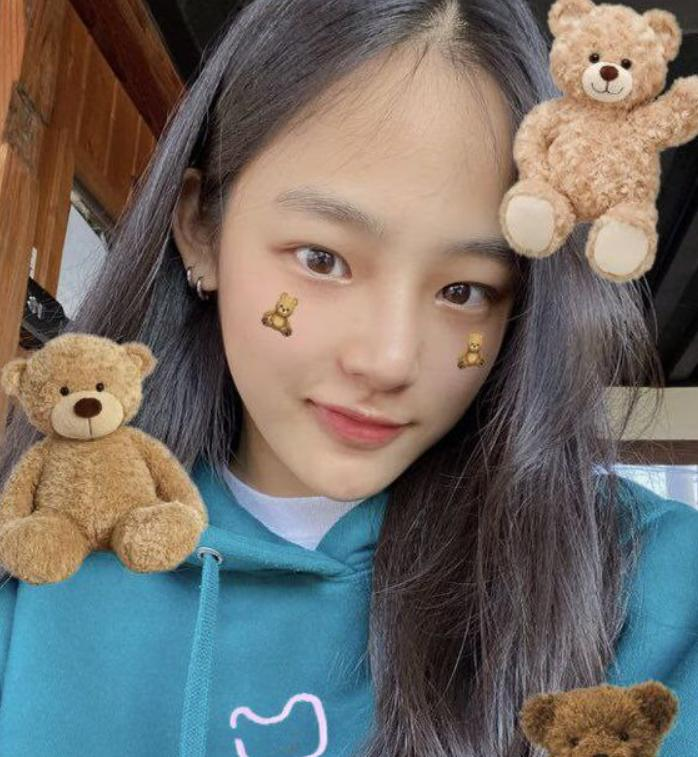

In [ ]:
# Load the answer dictionary from the saved JSON file
with open("/content/drive/MyDrive/answer_dict.json", "r") as json_file:
    answer_dict_parallel = json.loads(json_file.readline())

# Ask the user to input keywords
user_input = input("Enter keywords separated by commas or spaces to retrieve the associated photo: ")

# Check if the user wants to exit
if user_input.lower() == 'exit':
    sys.exit()  # Exit the program immediately

# Split the input string into keywords
keywords = [word.strip().lower() for word in user_input.split()]

# Find and display matching images
find_matching_images(results_parallel, keywords)


In [ ]:
# !pip install torch torchvision onnx onnx-tf tensorflow
# !pip install tf2onnx
# !pip install onnx tf2onnx tensorflow
# !pip install tensorflow onnx onnx-tf
# !pip install onnxsim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.7 MB/s eta 0:00:00


In [ ]:
# import torch
# import torchvision.models as models
# import torch.onnx
# import tensorflow as tf
# from onnx_tf.backend import prepare

# # Step 1: Load the PyTorch model
# pytorch_model = models.resnet18(pretrained=True)
# pytorch_model.eval()

# # Step 2: Convert PyTorch model to ONNX
# dummy_input = torch.randn(1, 3, 224, 224)
# onnx_path = "/content/drive/MyDrive/pytorch_Blipmodel.onnx"
# torch.onnx.export(pytorch_model, dummy_input, onnx_path, verbose=True, input_names=["input"], output_names=["output"])

# # Step 3: Convert ONNX to TensorFlow
# onnx_model = onnx.load(onnx_path)
# tf_rep = prepare(onnx_model)

# # Step 4: Export TensorFlow model to SavedModel format
# output_path = "/content/drive/MyDrive/tf_Blip_model"
# tf_rep.export_graph(output_path)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 50.4MB/s]
INFO:absl:Function `__call__` contains input name(s) x, y with unsupported characters which will be renamed to transpose_62_x, mul_1_y in the SavedModel.
INFO:absl:Found untraced functions su

In [ ]:
# import tensorflow as tf

# # TensorFlow 모델이 있는 폴더의 경로
# tensorflow_model_path = "/content/drive/MyDrive/tf_Blip_model/"

# # TFLite 모델로 저장될 경로 및 파일 이름
# tflite_model_path = "/content/drive/MyDrive/Blip_model.tflite"

# # TFLite 변환 옵션 설정
# converter = tf.lite.TFLiteConverter.from_saved_model(tensorflow_model_path)
# tflite_model = converter.convert()

# # TFLite 모델을 파일로 저장
# with open(tflite_model_path, "wb") as f:
#     f.write(tflite_model)

# print(f"TensorFlow Lite model successfully saved at: {tflite_model_path}")



TensorFlow Lite model successfully saved at: /content/drive/MyDrive/Blip_model.tflite
